<h3 style='color:blue' align='left'>Customer Churn Prediction Using Artificial Neural Network (ANN)</h3>

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Check CPU/DPU Devices
# My scomputer with GeForce RTX
import tensorflow as tf
print('***tf.config.experimental.list_physical_devices()***:')
print(tf.config.experimental.list_physical_devices())
print()
print('***tf.__version__***:', tf.__version__)     # 2.41.1
print()
print('***tf.test.is_built_with_cuda()***:', tf.test.is_built_with_cuda()) # True

2024-04-04 21:06:50.597091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 21:06:50.597119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 21:06:50.598053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 21:06:50.603737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 21:06:51.387881: W tensorflow/compiler/tf2

***tf.config.experimental.list_physical_devices()***:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

***tf.__version__***: 2.15.0

***tf.test.is_built_with_cuda()***: True


2024-04-04 21:06:52.009513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 21:06:52.044808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 21:06:52.045011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**Load the data**

In [3]:
df = pd.read_csv("telco_customer_churn.csv")
df.sample(5)

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
6801  6668-CNMFP  Female              0     Yes        Yes      19   
5719  1089-XZWHH  Female              0     Yes        Yes      24   
3283  1085-LDWAM  Female              0     Yes        Yes      69   
930   5146-CBVOE  Female              0      No         No      16   
2341  4304-TSPVK  Female              0     Yes         No      68   

     PhoneService MultipleLines InternetService       OnlineSecurity  ...  \
6801          Yes           Yes     Fiber optic                   No  ...   
5719          Yes            No              No  No internet service  ...   
3283          Yes            No              No  No internet service  ...   
930           Yes            No     Fiber optic                   No  ...   
2341          Yes           Yes     Fiber optic                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
6801                   No                  Yes                   No   
5719  No internet service  No internet service  No internet service   
3283  No internet service  No internet service  No internet service   
930                    No                   No                   No   
2341                  Yes                  Yes                  Yes   

          StreamingMovies        Contract PaperlessBilling  \
6801                  Yes        One year              Yes   
5719  No internet service        Two year              Yes   
3283  No internet service        One year              Yes   
930                    No  Month-to-month               No   
2341                  Yes        Two year               No   

                  PaymentMethod MonthlyCharges  TotalCharges Churn  
6801  Bank transfer (automatic)          89.35       1686.85    No  
5719               Mailed check          19.70        494.05    No  
3283    Credit card (automatic)          20.35       1442.65    No  
930   Bank transfer (automatic)          75.10       1212.85    No  
2341  Bank transfer (automatic)         114.90       7843.55    No  

[5 rows x 21 columns]

**First of all, drop customerID column as it is of no use**

In [4]:
df.drop('customerID',axis='columns',inplace=True)

In [5]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with  this column**

In [6]:
print('df.TotalCharges.values:', df.TotalCharges.values)
# df.TotalCharges.values: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
print('df.MonthlyCharges.values:', df.MonthlyCharges.values)
# df.MonthlyCharges.values: [ 29.85  56.95  53.85 ...  29.6   74.4  105.65]

df.TotalCharges.values: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
df.MonthlyCharges.values: [ 29.85  56.95  53.85 ...  29.6   74.4  105.65]


**Ahh... it is string. Lets convert it to numbers**

In [7]:
#pd.to_numeric(df.TotalCharges)
#We are getting error because there are some values are spaces (" ").

**Hmmm... some values seems to be not numbers but blank string. Let's find out such rows**

In [8]:
# We can use 'coerce' to set the row objec to True if data is NULL (' ').
# Below, we can see res1 is False (not null). 
# Only 11 is null (' '): True. Most (7032) are not null: (False)
res = pd.to_numeric(df.TotalCharges, errors='coerce').isnull()
index_cnt = 0
null_cnt = 0
not_null_cnt = 0
for res1 in res:
    if res1 == True:
        print(index_cnt, " res1: ", res1)
        null_cnt += 1
    else:
        not_null_cnt += 1
    index_cnt += 1
print('null_cnt:', null_cnt)
print('not_null_cnt:', not_null_cnt)
print('index_cnt:', index_cnt)
# errors{‘ignore’, ‘raise’, ‘coerce’}, default ‘raise’
# If ‘raise’, then invalid parsing will raise an exception.
# If ‘coerce’, then invalid parsing will be set as NaN.
# If ‘ignore’, then invalid parsing will return the input.

488  res1:  True
753  res1:  True
936  res1:  True
1082  res1:  True
1340  res1:  True
3331  res1:  True
3826  res1:  True
4380  res1:  True
5218  res1:  True
6670  res1:  True
6754  res1:  True
null_cnt: 11
not_null_cnt: 7032
index_cnt: 7043


In [9]:
# We use 'coerce' to set the object to True for ' ' (null).
# If data is number (not null), then object is False.
pd.to_numeric(df.TotalCharges, errors='coerce').isnull()
# There are only few (11) are "True". Most (7032) of them are "False" 

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [10]:
# We convert all of the not NULL data into numberic.
df2 = df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]
# we print all the Null TotalCharges.
print('df2:')
print(df2)
print('len(df2):')
print(len(df2))

df2:
      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753             

In [11]:
df.shape

(7043, 20)

In [12]:
df.iloc[488].TotalCharges

' '

In [13]:
df.iloc[753].TotalCharges

' '

In [14]:
df[df.TotalCharges!=' '].shape

(7032, 20)

In [15]:
7043-7032

11

**Remove rows with space in TotalCharges**

In [16]:
# We convert not null to df1.
# We drop the null data to df1.
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [17]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [18]:
# We convert 7032 instead of 7034.
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

/tmp/ipykernel_58055/1768493754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [19]:
print('df1.TotalCharges.values:', df1.TotalCharges.values)
print('df1.TotalCharges.dtypes:', df1.TotalCharges.dtypes)

df1.TotalCharges.values: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
df1.TotalCharges.dtypes: float64


In [20]:
df1[df1.Churn=='No']

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
3       Male              0      No         No      45           No   
6       Male              0      No        Yes      22          Yes   
7     Female              0      No         No      10           No   
...      ...            ...     ...        ...     ...          ...   
7037  Female              0      No         No      72          Yes   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService       OnlineSecurity  \
0     No phone service             DSL                   No   
1                   No             DSL                  Yes   
3     No phone service             DSL                  Yes   
6                  Yes     Fiber optic                   No   
7     No phone service             DSL                  Yes   
...                ...             ...                  ...   
7037                No              No  No internet service   
7038               Yes             DSL                  Yes   
7039               Yes     Fiber optic                   No   
7040  No phone service             DSL                  Yes   
7042                No     Fiber optic                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                   No                   No   
1                      No                  Yes                   No   
3                      No                  Yes                  Yes   
6                     Yes                   No                   No   
7                      No                   No                   No   
...                   ...                  ...                  ...   
7037  No internet service  No internet service  No internet service   
7038                   No                  Yes                  Yes   
7039                  Yes                  Yes                   No   
7040                   No                   No                   No   
7042                   No                  Yes                  Yes   

              StreamingTV      StreamingMovies        Contract  \
0                      No                   No  Month-to-month   
1                      No                   No        One year   
3                      No                   No        One year   
6                     Yes                   No  Month-to-month   
7                      No                   No  Month-to-month   
...                   ...                  ...             ...   
7037  No internet service  No internet service        Two year   
7038                  Yes                  Yes        One year   
7039                  Yes                  Yes        One year   
7040                   No                   No  Month-to-month   
7042                  Yes                  Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes           Electronic check           29.85   
1                  No               Mailed check           56.95   
3                  No  Bank transfer (automatic)           42.30   
6                 Yes    Credit card (automatic)           89.10   
7                  No               Mailed check           29.75   
...               ...                        ...             ...   
7037              Yes  Bank transfer (automatic)           21.15   
7038              Yes               Mailed check           84.80   
7039              Yes    Credit card (automatic)          103.20   
7040              Yes           Electronic check           29.60   
70

**Data Visualization**

df1[df1.Churn=='No'].tenure:
0        1
1       34
3       45
6       22
7       10
        ..
7037    72
7038    24
7039    72
7040    11
7042    66
Name: tenure, Length: 5163, dtype: int64
tenure_churn_no:
0        1
1       34
3       45
6       22
7       10
        ..
7037    72
7038    24
7039    72
7040    11
7042    66
Name: tenure, Length: 5163, dtype: int64


(array([[ 877.,  259.,  159.,  114.,  102.,   98.,   72.,   70.,   46.,
           72.],
        [ 847.,  476.,  402.,  424.,  371.,  346.,  380.,  425.,  455.,
         1037.]]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <a list of 2 BarContainer objects>)

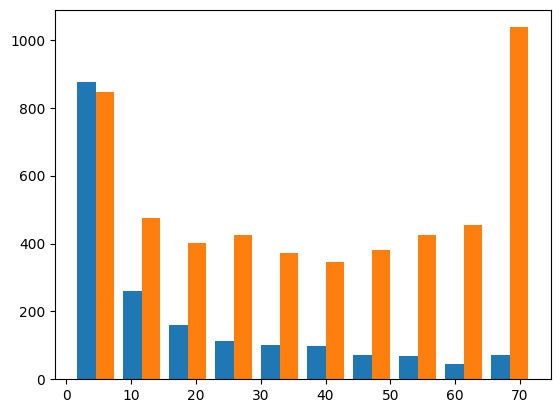

In [21]:
# We visualize the Tensure.
# Draw the history is a good idea.
# To see the customer distribution of "Not Leaving".
print("df1[df1.Churn=='No'].tenure:")
print(df1[df1.Churn=='No'].tenure)
# We assign the customer is not leaveing (Churn = 'No')
tenure_churn_no = df1[df1.Churn=='No'].tenure
print('tenure_churn_no:')
print(tenure_churn_no)
# We assign the customer is leaveing (Churn = 'Yes')
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure
# We display customer 'is not leaving' and 'is leaving'. 
plt.hist([tenure_churn_yes, tenure_churn_no])

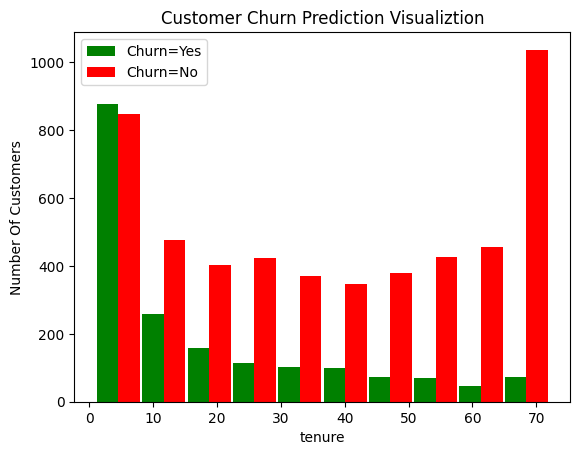

In [22]:
# We make the display with labels: Customer ount vs tensure 
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

#blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
#blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, 
         color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()
# Longer tenure will not leave.

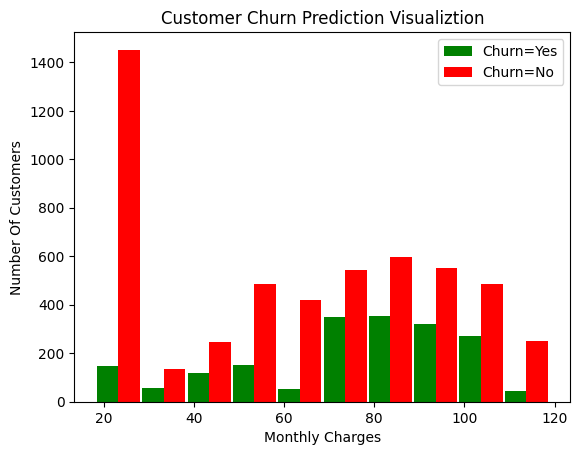

In [23]:
# Customer count vs. Mondy amount Charge
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges      
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

#blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
#blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()
# High monthly pay customer will leave (churn = yes)

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**

In [24]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [25]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [26]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

/tmp/ipykernel_58055/2045096646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service','No',inplace=True)
/tmp/ipykernel_58055/2045096646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service','No',inplace=True)


In [27]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to 1 or 0**

In [28]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

/tmp/ipykernel_58055/1648037665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col].replace({'Yes': 1,'No': 0},inplace=True)


In [29]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [30]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

/tmp/ipykernel_58055/698335744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['gender'].replace({'Female':1,'Male':0},inplace=True)


In [31]:
df1.gender.unique()

array([1, 0])

**One hot encoding for categorical columns**

In [32]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [33]:
df2.sample(5)

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
4511       0              0        0           1      17             1   
4542       1              1        1           0      32             1   
3384       1              0        1           1       4             1   
2287       0              1        1           0      69             1   
2582       1              0        0           1      12             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
4511              0               0             1                 1  ...   
4542              1               0             0                 1  ...   
3384              0               0             0                 1  ...   
2287              1               0             1                 1  ...   
2582              1               0             1                 1  ...   

      InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
4511                    1                            0                   0   
4542                    0                            1                   0   
3384                    0                            1                   0   
2287                    0                            1                   0   
2582                    0                            1                   0   

      Contract_Month-to-month  Contract_One year  Contract_Two year  \
4511                        0                  1                  0   
4542                        1                  0                  0   
3384                        1                  0                  0   
2287                        0                  0                  1   
2582                        1                  0                  0   

      PaymentMethod_Bank transfer (automatic)  \
4511                                        0   
4542                                        0   
3384                                        0   
2287                                        1   
2582                                        0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
4511                                      0                               1   
4542                                      0                               0   
3384                                      0                               1   
2287                                      0                               0   
2582                                      0                               1   

      PaymentMethod_Mailed check  
4511                           0  
4542                           1  
3384                           0  
2287                           0  
2582                           0  

[5 rows x 27 columns]

In [34]:
print("df2['tenure'].loc[:2]:")
print(df2['tenure'].loc[:2])
print()
print("df2['MonthlyCharges'].loc[:2]:")
print(df2['MonthlyCharges'].loc[:2])
print()
print("df2['TotalCharges']loc[:2]:")
print(df2['TotalCharges'].loc[:2])

df2['tenure'].loc[:2]:
0     1
1    34
2     2
Name: tenure, dtype: int64

df2['MonthlyCharges'].loc[:2]:
0    29.85
1    56.95
2    53.85
Name: MonthlyCharges, dtype: float64

df2['TotalCharges']loc[:2]:
0      29.85
1    1889.50
2     108.15
Name: TotalCharges, dtype: float64


In [35]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [36]:
df2.sample(5)

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
5407       1              0        1           1  0.873239             1   
6121       1              0        1           1  0.098592             1   
6829       0              0        1           1  0.098592             1   
3207       1              0        0           0  0.056338             1   
3635       1              0        1           0  1.000000             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
5407              0               1             1                 1  ...   
6121              0               0             0                 0  ...   
6829              0               0             0                 0  ...   
3207              0               0             0                 0  ...   
3635              1               0             0                 0  ...   

      InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
5407                    1                            0                   0   
6121                    0                            0                   1   
6829                    0                            0                   1   
3207                    0                            0                   1   
3635                    0                            0                   1   

      Contract_Month-to-month  Contract_One year  Contract_Two year  \
5407                        0                  0                  1   
6121                        0                  0                  1   
6829                        0                  0                  1   
3207                        1                  0                  0   
3635                        0                  0                  1   

      PaymentMethod_Bank transfer (automatic)  \
5407                                        0   
6121                                        1   
6829                                        0   
3207                                        0   
3635                                        0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
5407                                      0                               0   
6121                                      0                               0   
6829                                      1                               0   
3207                                      1                               0   
3635                                      0                               1   

      PaymentMethod_Mailed check  
5407                           1  
6121                           0  
6829                           0  
3207                           0  
3635                           0  

[5 rows x 27 columns]

In [37]:
# Check the Scale data.
print("df2['tenure'].loc[:2]:")
print(df2['tenure'].loc[:2])
print()
print("df2['MonthlyCharges'].loc[:2]:")
print(df2['MonthlyCharges'].loc[:2])
print()
print("df2['TotalCharges'].loc[:2]:")
print(df2['TotalCharges'].loc[:2])

df2['tenure'].loc[:2]:
0    0.000000
1    0.464789
2    0.014085
Name: tenure, dtype: float64

df2['MonthlyCharges'].loc[:2]:
0    0.115423
1    0.385075
2    0.354229
Name: MonthlyCharges, dtype: float64

df2['TotalCharges'].loc[:2]:
0    0.001275
1    0.215867
2    0.010310
Name: TotalCharges, dtype: float64


In [38]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                     float64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [39]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

**Train test split**

In [40]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [41]:
X_train.shape

(5625, 26)

In [42]:
X_test.shape

(1407, 26)

In [43]:
X_train[:10]

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
5664       1              1        0           0  0.126761             1   
101        1              0        1           1  0.000000             1   
2621       0              0        1           0  0.985915             1   
392        1              1        0           0  0.014085             1   
1327       0              0        1           0  0.816901             1   
3607       1              0        0           0  0.169014             1   
2773       0              0        1           0  0.323944             0   
1936       1              0        1           0  0.704225             1   
5387       0              0        0           0  0.042254             0   
4331       0              0        0           0  0.985915             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
5664              0               0             0                 1  ...   
101               0               0             0                 0  ...   
2621              0               0             1                 1  ...   
392               0               0             0                 0  ...   
1327              1               0             0                 1  ...   
3607              0               1             0                 0  ...   
2773              0               0             0                 1  ...   
1936              0               1             1                 0  ...   
5387              0               0             0                 0  ...   
4331              1               0             0                 0  ...   

      InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
5664                    0                            1                   0   
101                     0                            0                   1   
2621                    1                            0                   0   
392                     1                            0                   0   
1327                    0                            1                   0   
3607                    1                            0                   0   
2773                    1                            0                   0   
1936                    1                            0                   0   
5387                    1                            0                   0   
4331                    0                            0                   1   

      Contract_Month-to-month  Contract_One year  Contract_Two year  \
5664                        1                  0                  0   
101                         1                  0                  0   
2621                        0                  0                  1   
392                         1                  0                  0   
1327                        0                  1                  0   
3607                        0                  1                  0   
2773                        1                  0                  0   
1936                        0                  1                  0   
5387                        1                  0                  0   
4331                        0                  0                  1   

      PaymentMethod_Bank transfer (automatic)  \
5664                                        0   
101                                         0   
2621                                        0   
392                                         0   
1327                                        1   
3607                                        0   
2773                                        0   
1936                                        1   
5387                                        0   
4331                                        1   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
5664                                      1                             

In [44]:
len(X_train.columns)

26

**Build a model (ANN) in tensorflow/keras**

In [45]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100


2024-04-04 21:06:54.012704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 21:06:54.012933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 21:06:54.013074: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

176/176 [==============================] - 2s 2ms/step - loss: 0.5142 - accuracy: 0.7481
Epoch 2/100
176/176 [==============================] - 1s 3ms/step - loss: 0.4293 - accuracy: 0.7908
Epoch 3/100
176/176 [==============================] - 1s 4ms/step - loss: 0.4202 - accuracy: 0.7941
Epoch 4/100
176/176 [==============================] - 1s 5ms/step - loss: 0.4175 - accuracy: 0.7972
Epoch 5/100
176/176 [==============================] - 1s 5ms/step - loss: 0.4147 - accuracy: 0.8055
Epoch 6/100
176/176 [==============================] - 1s 4ms/step - loss: 0.4123 - accuracy: 0.8032
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4105 - accuracy: 0.8052
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.8053
Epoch 9/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8057
Epoch 10/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4066 - accuracy: 0.8096
E

In [46]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.7683


[0.48977237939834595, 0.7683013677597046]

In [47]:
yp = model.predict(X_test)
yp[:5]

44/44 [==============================] - 0s 1ms/step


array([[0.390546  ],
       [0.4478836 ],
       [0.00633413],
       [0.81576604],
       [0.34618333]], dtype=float32)

In [48]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [49]:
y_pred[:10]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 1]

In [50]:
y_test.iloc[:10]

2660    0
744     0
5579    1
64      1
3287    1
816     1
2670    0
5920    0
1023    0
6087    0
Name: Churn, dtype: int64

In [51]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       999
           1       0.61      0.58      0.59       408

    accuracy                           0.77      1407
   macro avg       0.72      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407



Text(95.72222222222221, 0.5, 'Truth')

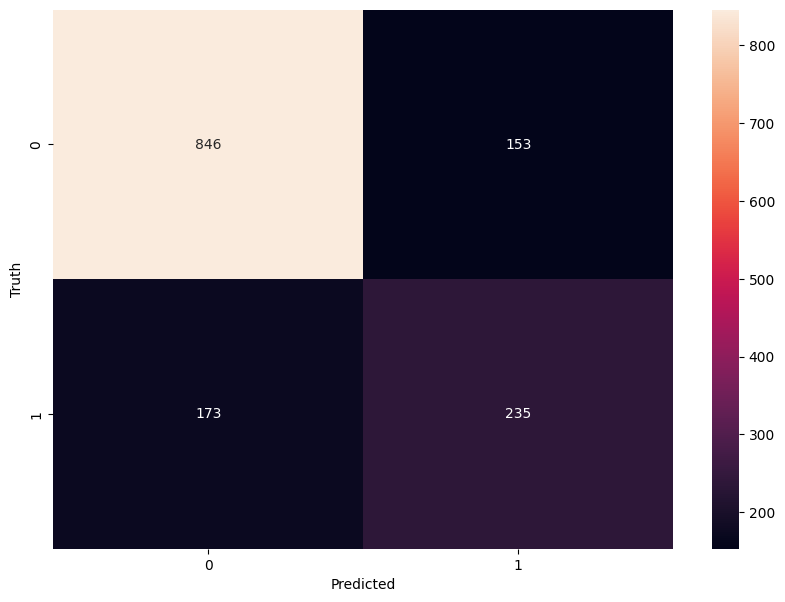

In [52]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [53]:
y_test.shape

(1407,)

**Accuracy**

In [54]:
#  862 | 137
#  ----------
#  179 | 229
# round((862+229)/(862+229+137+179),2) 

#  872 | 127
#  ----------
#  190 | 218
round((872+218)/(872+218+127+190),2) 

0.77

**Precision for 0 class. i.e. Precision for customers who did not churn**

In [55]:
#  862 | 137
#  ----------
#  179 | 229
# round(862/(862+179),2)

#  872 | 127
#  ----------
#  190 | 218
round(872/(872+190),2)   

0.82

**Precision for 1 class. i.e. Precision for customers who actually churned**

In [56]:
#  862 | 137
#  ----------
#  179 | 229
# round(229/(229+137),2)

#  872 | 127
#  ----------
#  190 | 218
round(218/(218+127),2)  

0.63

**Recall for 0 class**

In [57]:
#  862 | 137
#  ----------
#  179 | 229
# round(862/(862+137),2)

#  872 | 127
#  ----------
#  190 | 218
round(872/(872+127),2) 

0.87

**Recall for 1 class**

In [58]:
#  862 | 137
#  ----------
#  179 | 229
# round(229/(229+179),2)

#  872 | 127
#  ----------
#  190 | 218
round(218/(218+190),2)  

0.53

**Exercise**

Take this dataset for bank customer churn prediction : https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

1) Build a deep learning model to predict churn rate at bank. 

2) Once model is built, print classification report and analyze precision, recall and f1-score 